# Collection

Collection is the basic class for processing and organizing data files. Collection just records status of the file selection. It does not make a copy of the files. But you can use collection to modify/add files at the raw data path. The modified data will be stored locally.

## Basic Assumptions about the Dataset

A **Dataset** is considered to be a folder where all images/data are stored. The name for these imgaes/data is assumed to be `*[field name]*[field id]*[field extension].[file extension]`
I choose **field** because for some dataset (like INRIA), they use city name to represents images that comes from different geo-locations. However, in MIT road dataset, they use 'training', 'validation' and 'testing' to distinguish the paper. So the **field** here is just a term to represent some higher level label of the images/data. 
1. _field name_: name of the field, e.g., 'austin' in INRIA
2. _field id_: numerical id of the field, e.g., tile number in INRIA
3. _field extension_: this is not file extension, it's the suffix of the image name, e.g., 'RGB' or 'GT' in INRIA
4. _file extension_: file extension, is the last few digits of the file, indicates type of the file

A regular expression is used to select the files, so this assumption can work as long as the order of the four bullets above is the same. Some of them can be blank

In [1]:
# this is for path management in jupyter notebook
# note necessary if you're running in terminal or other IDEs
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

## Create a Collection

In [2]:
from collection import collectionMaker

In [3]:
cm = collectionMaker.CollectionMaker(r'/media/ei-edl01/user/bh163/ersa_data_temp/inria_toy', # data path to raw data
                                     field_name='austin,chicago,tyrol-w', # multi field names can use , to separate
                                     field_id='1,2', # multi field id can use , to separate
                                     rgb_ext='RGB', # multi rgb extensions can use , to seperate
                                     gt_ext='GT', # you can only have one truth extension per collection
                                     file_ext='tif', # file extension, can be a single string if they are the same
                                     force_run=True, 
                                     clc_name='inria_demo', # name of the collection created
                                    ) 

Start running collection_maker


Calculating means: 100%|██████████| 6/6 [00:38<00:00,  6.05s/it]


Now I shall have a new collection located in a folder named 'inria_demo'. The full path should be determined by [ersaPath.py](../ersaPath.py)

## Exam a Collection

We can view a summary of the dataset by calling the function `print_meta_data()`

In [4]:
cm.print_meta_data()

=======================================inria_demo=======================================
raw_data_path: /media/ei-edl01/user/bh163/ersa_data_temp/inria_toy
field_name: ['austin', 'chicago', 'tyrol-w']
field_id: ['1', '2']
clc_name: inria_demo
tile_dim: (5000, 5000)
chan_mean: [103.64270292 112.54243129 104.79410679]
Source file: *RGB*.tif
GT file: *GT*.tif


We can also load a file from the collection even without the full name

In [5]:
import matplotlib.pyplot as plt
import utils
%matplotlib inline

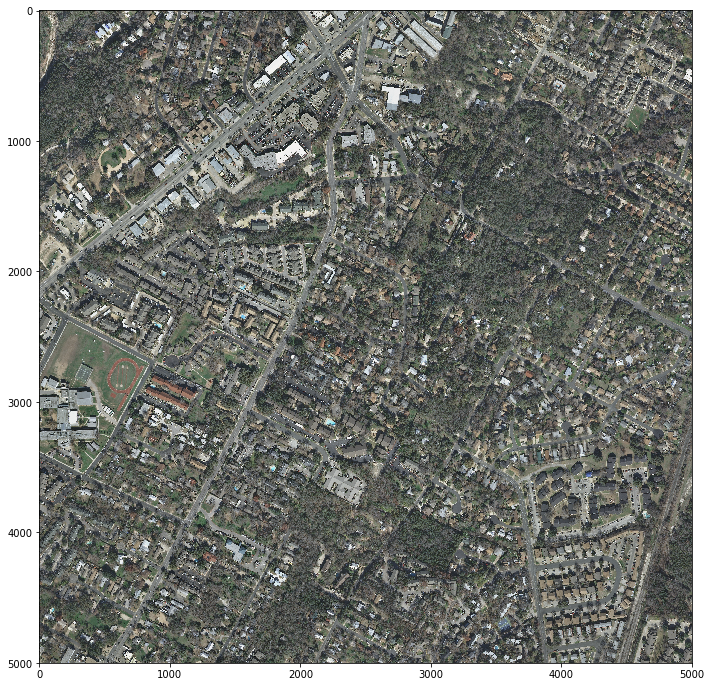

In [6]:
file = cm.load_files('austin', '2', 'RGB')
plt.figure(figsize=(12, 12))
plt.imshow(utils.load_file(file))
plt.show()

## Edit Collection

### Single Channel Operation

In [7]:
import numpy as np
from collection import collectionEditor

In [8]:
gt_m2 = collectionEditor.SingleChanMult(cm.clc_dir, # path to the collection or where the images are stored
                                          2, # the multifactor
                                          ['GT', 'gt_m2'], # the old field extension to operate on and the new one
                                         ).run(force_run=True, 
                                               file_ext='png', 
                                               # you can change the file extension, 
                                               # you can also leave it if you want to keep the old one
                                               d_type=np.float32, # data type of the processed data
    )

  0%|          | 0/6 [00:00<?, ?it/s]

Start running chan_mult_2p00000


/home/lab/anaconda3/envs/tf-aml/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [0.0, 254.0]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
Making tyrol-w2_gt_m2.png: 100%|██████████| 6/6 [00:15<00:00,  2.56s/it]


### Add a Channel

You can add a channel to the collection. Here we add the one we just created.
**Note**: you can only add this as rgb files. No more than one ground truth extensions can exists in one collection.

In [9]:
cm.add_channel(gt_m2.files, # files to add
               'gt_m2', # new channel name
              )

Start running collection_maker


Calculating means: 100%|██████████| 6/6 [00:07<00:00,  1.15s/it]


Now the meta data have also updated. 'gt_m2' has been added to the 'source file' field, can the channel mean has four elements now.

In [10]:
cm.print_meta_data()

=======================================inria_demo=======================================
raw_data_path: /media/ei-edl01/user/bh163/ersa_data_temp/inria_toy
field_name: ['austin', 'chicago', 'tyrol-w']
field_id: ['1', '2']
clc_name: inria_demo
tile_dim: (5000, 5000)
chan_mean: [103.64270292 112.54243129 104.79410679  37.5233894 ]
Source file: *RGB*.tif *gt_m2*.png
GT file: *GT*.tif


### Replace a Channel

Sometimes the ground truth in original data are in [0, 255] so the file can be visible in computer's image viewer. But this is not the desired input for CNNs, we need to map it back to [0, 1].
We can do this by setting the multifactor as 1/255.

In [11]:
# divide channel number by 255
# this is very commonly used if the original ground truth are in [0, 255] instead of [0, 1]
gt_d255 = collectionEditor.SingleChanMult(cm.clc_dir, # path to the collection or where the images are stored
                                          1/255, # the multifactor
                                          ['GT', 'gt_d255'], # the old field extension to operate on and the new one
                                         ).run(force_run=True, 
                                               file_ext='png', 
                                               # you can change the file extension, 
                                               # you can also leave it if you want to keep the old one
                                               d_type=np.uint8, # data type of the processed data
    )

  0%|          | 0/6 [00:00<?, ?it/s]

Start running chan_mult_1d255


Making tyrol-w2_gt_d255.png: 100%|██████████| 6/6 [00:14<00:00,  2.31s/it]


Now we have the ground truth channel mapped to [0, 1], we need to replace the old ground truth with the new one. We can just replace the ground truth channel.

In [12]:
cm.replace_channel(gt_d255.files, # new files to replace the old ones
                   True, # it is used to replace ground truth
                   ['GT', 'gt_d255'], # old field extension and the new field extension
                  )

Start running collection_maker


Calculating means: 100%|██████████| 6/6 [00:06<00:00,  1.15s/it]


Now let's take a look at the meta data, the gt field has been updated to 'gt_d255' from 'GT'

In [13]:
cm.print_meta_data()

=======================================inria_demo=======================================
raw_data_path: /media/ei-edl01/user/bh163/ersa_data_temp/inria_toy
field_name: ['austin', 'chicago', 'tyrol-w']
field_id: ['1', '2']
clc_name: inria_demo
tile_dim: (5000, 5000)
chan_mean: [103.64270292 112.54243129 104.79410679  37.5233894 ]
Source file: *RGB*.tif *gt_m2*.png
GT file: *gt_d255*.png
